# Summary
This notebook loads the M5 dataset and creates a pair of naive test model. One forecasts the next 28 days as averages for the past 28 days. The other forecasts the next 28 days as a repeat of the past 28 days.

The main purpose is to test the `m5_evaluation` function found in `m5_utils.py`. The function takes in a forecast submission in the same format as used for the Kaggle competition and calculates RMSE. The test period used by the function is **day 1914 through day 1941**.

# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from m5_utils import m5_evaluation

# Load Data
This borrows from `load_m5_dataset.ipynb`.

Data details from the original M5 project: https://mofc.unic.ac.cy/wp-content/uploads/2020/03/M5-Competitors-Guide-Final-10-March-2020.docx

## File 1: “calendar.csv” 
Contains information about the dates the products are sold.
* date: The date in a “y-m-d” format.
* wm_yr_wk: The id of the week the date belongs to.
weekday: The type of the day (Saturday, Sunday, …, Friday).
* **wday**: The id of the weekday, starting from Saturday.
* **month**: The month of the date.
* **year**: The year of the date.
* **event_name_1**: If the date includes an event, the name of this event.
* **event_type_1**: If the date includes an event, the type of this event.
* **event_name_2**: If the date includes a second event, the name of this event.
* **event_type_2**: If the date includes a second event, the type of this event.
* **snap_CA, snap_TX, and snap_WI**: A binary variable (0 or 1) indicating whether the stores of CA, TX or WI allow SNAP[1] purchases on the examined date. 1 indicates that SNAP purchases are allowed.

## File 2: “sell_prices.csv”
Contains information about the price of the products sold per store and date.
* **store_id**: The id of the store where the product is sold. 
* **item_id**: The id of the product.
* **wm_yr_wk**: The id of the week.
* **sell_price**: The price of the product for the given week/store. The price is provided per week (average across seven days). If not available, this means that the product was not sold during the examined week. Note that although prices are constant at weekly basis, they may change through time (both training and test set).

## File 3: “sales_train.csv” 
Contains the historical daily unit sales data per product and store.
* **item_id**: The id of the product.
* **dept_id**: The id of the department the product belongs to.
* **cat_id**: The id of the category the product belongs to.
* **store_id**: The id of the store where the product is sold.
* **state_id**: The State where the store is located.
* **d_1, d_2, …, d_i, … d_1941**: The number of units sold at day i, starting from 2011-01-29. 

**Footnotes**

[1] The United States federal government provides a nutrition assistance benefit called the Supplement Nutrition Assistance Program (SNAP).  SNAP provides low income families and individuals with an Electronic Benefits Transfer debit card to purchase food products.  In many states, the monetary benefits are dispersed to people across 10 days of the month and on each of these days 1/10 of the people will receive the benefit on their card.  More information about the SNAP program can be found here: https://www.fns.usda.gov/snap/supplemental-nutrition-assistance-program 

In [2]:
m5_input_path = "/ssd003/projects/forecasting_bootcamp/bootcamp_datasets/m5-forecasting-accuracy"
calendar = pd.read_csv(f'{m5_input_path}/calendar.csv')
sell_price = pd.read_csv(f'{m5_input_path}/sell_prices.csv')
sales_train_eval = pd.read_csv(f'{m5_input_path}/sales_train_evaluation.csv').set_index('id')
sample_sub = pd.read_csv(f'{m5_input_path}/sample_submission.csv')

In [3]:
# Get column groups
cat_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
ts_cols = [col for col in sales_train_eval.columns if col not in cat_cols]
ts_dict = {t: int(t[2:]) for t in ts_cols}

In [4]:
sample_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60980 entries, 0 to 60979
Data columns (total 29 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      60980 non-null  object
 1   F1      60980 non-null  int64 
 2   F2      60980 non-null  int64 
 3   F3      60980 non-null  int64 
 4   F4      60980 non-null  int64 
 5   F5      60980 non-null  int64 
 6   F6      60980 non-null  int64 
 7   F7      60980 non-null  int64 
 8   F8      60980 non-null  int64 
 9   F9      60980 non-null  int64 
 10  F10     60980 non-null  int64 
 11  F11     60980 non-null  int64 
 12  F12     60980 non-null  int64 
 13  F13     60980 non-null  int64 
 14  F14     60980 non-null  int64 
 15  F15     60980 non-null  int64 
 16  F16     60980 non-null  int64 
 17  F17     60980 non-null  int64 
 18  F18     60980 non-null  int64 
 19  F19     60980 non-null  int64 
 20  F20     60980 non-null  int64 
 21  F21     60980 non-null  int64 
 22  F22     60980 non-null

In [5]:
sample_sub.head()

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
sales_train_eval.info()

<class 'pandas.core.frame.DataFrame'>
Index: 30490 entries, HOBBIES_1_001_CA_1_evaluation to FOODS_3_827_WI_3_evaluation
Columns: 1946 entries, item_id to d_1941
dtypes: int64(1941), object(5)
memory usage: 452.9+ MB


In [7]:
sales_train_eval.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,d_5,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


# Tests

## Fraction of Observations that are Zeros

In [8]:
test_zeros = (
    sales_train_eval
    .drop(cat_cols, axis=1)
    .isin([0])
    .sum(axis=0)
    .transpose()
)

In [9]:
df_test_zeros = test_zeros.to_frame(name='zeros')
df_test_zeros['frac_zero'] = df_test_zeros.zeros / len(sales_train_eval)
print(df_test_zeros)

        zeros  frac_zero
d_1     23511   0.771105
d_2     23610   0.774352
d_3     24500   0.803542
d_4     24518   0.804133
d_5     25422   0.833782
...       ...        ...
d_1937  17561   0.575959
d_1938  17473   0.573073
d_1939  16616   0.544966
d_1940  15235   0.499672
d_1941  14806   0.485602

[1941 rows x 2 columns]


<AxesSubplot:>

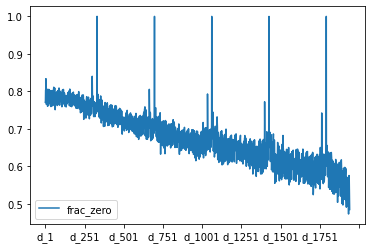

In [10]:
df_test_zeros.plot(y='frac_zero')

# Model Evaluation

In [11]:
df_truth = sales_train_eval.loc[:, [f'd_{x}' for x in range(1914, 1942)]]
df_truth.columns = [f'F{x+1}' for x in range(28)]
# df_truth.index = df_truth.index.str.replace(r'_evaluation$', '_validation', regex=True)
df_truth.sort_index(inplace=True)

In [12]:
df_truth

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
FOODS_1_001_CA_1_evaluation,2,0,0,0,0,1,1,0,6,1,...,2,3,1,0,0,0,1,0,0,0
FOODS_1_001_CA_2_evaluation,0,3,0,0,0,1,4,0,0,0,...,1,0,0,1,1,0,0,1,2,0
FOODS_1_001_CA_3_evaluation,1,0,1,0,8,1,0,0,1,0,...,1,2,2,0,0,1,0,3,2,2
FOODS_1_001_CA_4_evaluation,0,1,0,0,0,0,1,0,0,0,...,1,0,0,0,0,1,1,0,0,0
FOODS_1_001_TX_1_evaluation,0,0,1,0,1,0,1,1,1,1,...,1,1,1,1,5,0,2,2,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
HOUSEHOLD_2_516_TX_2_evaluation,0,0,0,0,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,1
HOUSEHOLD_2_516_TX_3_evaluation,0,0,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,1,1,2
HOUSEHOLD_2_516_WI_1_evaluation,1,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [13]:
df_truth.to_csv('m5_truth.csv')

In [14]:
eval_test = m5_evaluation(df_truth, df_truth, method='rmse')
print(eval_test)

0.0


# Naive Average Model
The forecast is an average of recent history.
 * Main purpose is to test scoring functions
 * A validation set is not used because there is hyperparameter tuning

In [15]:
df_test_naive_avg = sales_train_eval.loc[:, cat_cols + [f'd_{x}' for x in range(1914, 1942)]]

In [16]:
df_test_naive_avg.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1914,d_1915,d_1916,d_1917,d_1918,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,2,0,...,2,4,0,0,0,0,3,3,0,1
HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,1,0,0,0,...,0,1,2,1,1,0,0,0,0,0
HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,1,0,...,1,0,2,0,0,0,2,3,0,1
HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,1,2,4,...,1,1,0,4,0,1,3,0,2,6
HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,2,3,1,...,0,0,0,2,1,0,0,2,1,0


In [17]:
df_train_naive_avg = sales_train_eval.loc[:, cat_cols + [f'd_{x}' for x in range(1886, 1914)]]

In [18]:
df_train_naive_avg.head()

,item_id,dept_id,cat_id,store_id,state_id,d_1886,d_1887,d_1888,d_1889,d_1890,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,3,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1,0,4,4,0,...,2,1,1,0,1,1,2,2,2,4


In [19]:
df_naive_avg_forecast = df_train_naive_avg.drop(cat_cols, axis=1)
df_naive_avg_forecast.columns = [f'F{x+1}' for x in range(28)]
df_naive_avg_forecast.index = df_naive_avg_forecast.index.str.replace(r'_evaluation$', '_validation', regex=True)

In [20]:
# There is probably a faster way to do this, but it is not too many rows
# and this easily broadcasts the mean across the columns
# for i, row in df_naive_avg_forecast.iterrows():
#     df_naive_avg_forecast.loc[i, :] = np.mean(row)

In [21]:
# Much faster
df_naive_avgs = df_naive_avg_forecast.mean(axis=1).to_frame(name='F')
for col in df_naive_avg_forecast.columns:
    df_naive_avg_forecast[col] = df_naive_avgs.F

In [22]:
df_naive_avg_forecast

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,...,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286,0.964286
HOBBIES_1_002_CA_1_validation,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,...,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429,0.071429
HOBBIES_1_003_CA_1_validation,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,...,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429,0.571429
HOBBIES_1_004_CA_1_validation,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,...,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429,1.821429
HOBBIES_1_005_CA_1_validation,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,...,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143,1.357143
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,...,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286,0.214286
FOODS_3_824_WI_3_validation,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,...,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429,0.321429
FOODS_3_825_WI_3_validation,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,...,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857,0.892857


In [23]:
# Score
eval_naive_avg = m5_evaluation(df_naive_avg_forecast)
print(eval_naive_avg)

# Confirm that sorting in m5_evalutation works as expected
print(m5_evaluation(df_naive_avg_forecast.sort_index()))

# Confirm that the stored truth gives the same result as df_truth
print(m5_evaluation(df_naive_avg_forecast, df_truth))

1.3829026003226654
1.3829026003226654
1.3829026003226654


# Naive Repeat Model
Forecasts next 28 days as a repeat of the previous 28 days

In [24]:
df_naive_repeat_forecast = df_train_naive_avg.drop(cat_cols, axis=1)
df_naive_repeat_forecast.columns = [f'F{x+1}' for x in range(28)]
df_naive_repeat_forecast.index = df_naive_avg_forecast.index.str.replace(r'_evaluation$', '_validation', regex=True)

In [25]:
df_naive_repeat_forecast

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
id,,,,,,,,,,,,,,,,,,,,,
HOBBIES_1_001_CA_1_validation,1,0,0,0,0,0,1,0,4,2,...,1,3,0,1,1,1,3,0,1,1
HOBBIES_1_002_CA_1_validation,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,1,0,0,0,...,2,1,2,1,1,1,0,1,1,1
HOBBIES_1_004_CA_1_validation,0,0,0,0,3,1,2,1,3,1,...,1,0,5,4,1,0,1,3,7,2
HOBBIES_1_005_CA_1_validation,1,0,4,4,0,1,4,0,1,0,...,2,1,1,0,1,1,2,2,2,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,1,0,0,1
FOODS_3_824_WI_3_validation,0,0,0,0,0,1,1,2,0,0,...,0,0,0,0,0,0,0,0,1,0
FOODS_3_825_WI_3_validation,1,0,0,0,0,1,1,2,1,4,...,2,1,0,2,0,1,0,0,1,0


In [26]:
eval_naive_repeat = m5_evaluation(df_naive_repeat_forecast)
print(eval_naive_repeat)

1.8347764418263361
